In [1]:
import paddle
import paddle.vision.transforms as T
import numpy as np
from PIL import Image

# 设置随机种子
import random
seed = 2023
paddle.seed(seed)
random.seed(seed)
np.random.seed(seed)

BATCH_SIZE = 32 # 批次大小
EPOCH = 20   # 训练轮数
LR = 0.0001

class FishDataset(paddle.io.Dataset):
    """
    23种鱼数据集类的定义
    """

    def __init__(self, mode='train'):
        """
        初始化函数
        """
        assert mode in ['train', 'eval'], 'mode is one of train, eval.'

        self.data = []

        with open('data/{}.txt'.format(mode)) as f:
            for line in f.readlines():
                info = line.strip().split('\t')

                if len(info) > 0:
                    self.data.append([info[0].strip(), info[1].strip()])

        if mode == 'train':
            self.transforms = T.Compose([
                T.Resize((224,224)),    # 随机裁剪大小
                T.RandomHorizontalFlip(0.5),        # 随机水平翻转
                T.ToTensor(),                       # 数据的格式转换和标准化、 HWC => CHW 
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 图像归一化
            ])
        else:
            self.transforms = T.Compose([
                T.Resize((224,224)),                 # 图像大小修改
                T.ToTensor(),                  # 数据的格式转换和标准化 HWC => CHW
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # 图像归一化
            ])
        
    def __getitem__(self, index):
        """
        根据索引获取单个样本
        """
        image_file, label = self.data[index]
        image = Image.open(image_file)

        if image.mode != 'RGB':
            image = image.convert('RGB')

        image = self.transforms(image)

        return image, np.array([label], dtype='int64')

    def __len__(self):
        """
        获取样本总数
        """
        return len(self.data)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):


In [2]:
import paddle


train_dataset= FishDataset(mode='train')
eval_dataset=FishDataset(mode='eval')
#训练数据加载
train_loader = paddle.io.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#评估数据加载
eval_loader = paddle.io.DataLoader(eval_dataset, batch_size = 8, shuffle=False)

In [3]:
import paddle
#from paddle.nn import *

# 定义卷积池化网络
class ConvPool(paddle.nn.Layer):
    '''卷积+池化'''
    def __init__(self,
                 num_channels,
                 num_filters, 
                 filter_size,
                 pool_size,
                 pool_stride,
                 groups,
                 conv_stride=1, 
                 conv_padding=1,
                 ):
        super(ConvPool, self).__init__()  

        # groups代表卷积层的数量
        for i in range(groups):
            self.add_sublayer(   #添加子层实例
                'bb_%d' % i,
                paddle.nn.Conv2D(         # layer
                in_channels=num_channels, #通道数
                out_channels=num_filters,   #卷积核个数
                kernel_size=filter_size,   #卷积核大小
                stride=conv_stride,        #步长
                padding = conv_padding,    #padding
                )
            )
            self.add_sublayer(
                'relu%d' % i,
                paddle.nn.ReLU()
            )
            num_channels = num_filters
            

        self.add_sublayer(
            'Maxpool',
            paddle.nn.MaxPool2D(
            kernel_size=pool_size,           #池化核大小
            stride=pool_stride               #池化步长
            )
        )

    def forward(self, inputs):
        x = inputs
        for prefix, sub_layer in self.named_children():
            # print(prefix,sub_layer)
            x = sub_layer(x)
        return x
        

# VGG网络
class VGGNet(paddle.nn.Layer):
    def __init__(self):
        super(VGGNet, self).__init__()       
        # 5个卷积池化操作
        self.convpool01 = ConvPool(
            3, 64, 3, 2, 2, 2)  #3:通道数，64：卷积核个数，3:卷积核大小，2:池化核大小，2:池化步长，2:连续卷积个数
        self.convpool02 = ConvPool(
            64, 128, 3, 2, 2, 2)
        self.convpool03 = ConvPool(
            128, 256, 3, 2, 2, 3) 
        self.convpool04 = ConvPool(
            256, 512, 3, 2, 2, 3)
        self.convpool05 = ConvPool(
            512, 512, 3, 2, 2, 3)       
        self.pool_5_shape = 512 * 7* 7
        # 三个全连接层
        self.fc01 = paddle.nn.Linear(self.pool_5_shape, 4096)
        self.drop1 = paddle.nn.Dropout(p=0.5)
        self.fc02 = paddle.nn.Linear(4096, 4096)
        self.drop2 = paddle.nn.Dropout(p=0.5)
        self.fc03 = paddle.nn.Linear(4096, 23)

    def forward(self, inputs, label=None):
        # print('input_shape:', inputs.shape) #[8, 3, 224, 224]
        """前向计算"""
        out = self.convpool01(inputs)
        # print('convpool01_shape:', out.shape)           #[8, 64, 112, 112]
        out = self.convpool02(out)
        # print('convpool02_shape:', out.shape)           #[8, 128, 56, 56]
        out = self.convpool03(out)
        # print('convpool03_shape:', out.shape)           #[8, 256, 28, 28]
        out = self.convpool04(out)
        # print('convpool04_shape:', out.shape)           #[8, 512, 14, 14]
        out = self.convpool05(out)
        # print('convpool05_shape:', out.shape)           #[8, 512, 7, 7]         

        out = paddle.reshape(out, shape=[-1, 512*7*7])
        out = self.fc01(out)
        out = self.drop1(out)
        out = self.fc02(out)
        out = self.drop2(out)
        out = self.fc03(out)
        
        if label is not None:
            acc = paddle.metric.accuracy(input=out, label=label)
            return out, acc
        else:
            return out

In [4]:
import matplotlib.pyplot as plt
# 折线图，用于观察训练过程中loss和acc的走势
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [5]:
import paddle
from paddle.vision.models import VGG
from paddle.vision.models.vgg import make_layers




class my_model(paddle.nn.Layer):
    def __init__(self, num_classes=23):
        super().__init__()
        vgg11_cfg = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
        features = make_layers(vgg11_cfg)
        vgg11 = VGG(features,num_classes)        

        self.vgg11 = vgg11
    def forward(self,x,label):

        out = self.vgg11(x)

        if label is not None:
            acc = paddle.metric.accuracy(input=out, label=label)
            return out, acc
        else:
            return out

# 训练

W0607 23:31:31.662330  5361 device_context.cc:362] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0607 23:31:31.667730  5361 device_context.cc:372] device: 0, cuDNN Version: 7.6.
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:143: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy sc

epo: 0, step: 100, loss is: [0.79833543], acc is: [0.65625]
epo: 0, step: 200, loss is: [0.72485733], acc is: [0.8125]
epo: 0, step: 300, loss is: [0.63725674], acc is: [0.84375]
epo: 0, step: 400, loss is: [0.32318038], acc is: [0.9375]
epo: 0, step: 500, loss is: [0.5370636], acc is: [0.8125]
epo: 0, step: 600, loss is: [0.10039544], acc is: [0.96875]
epo: 0, step: 700, loss is: [0.26446062], acc is: [0.9375]
epo: 1, step: 800, loss is: [0.5022275], acc is: [0.84375]
epo: 1, step: 900, loss is: [0.06569137], acc is: [0.96875]
epo: 1, step: 1000, loss is: [0.23559594], acc is: [0.9375]
epo: 1, step: 1100, loss is: [0.13545433], acc is: [0.96875]
epo: 1, step: 1200, loss is: [0.25165638], acc is: [0.90625]
epo: 1, step: 1300, loss is: [0.03810532], acc is: [1.]
epo: 1, step: 1400, loss is: [0.2546644], acc is: [0.9375]
epo: 1, step: 1500, loss is: [0.2548697], acc is: [0.90625]
epo: 2, step: 1600, loss is: [0.04346835], acc is: [1.]
epo: 2, step: 1700, loss is: [0.06805632], acc is: [0

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


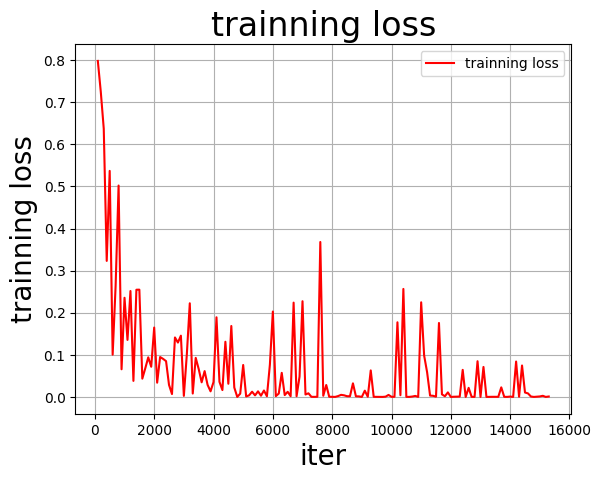

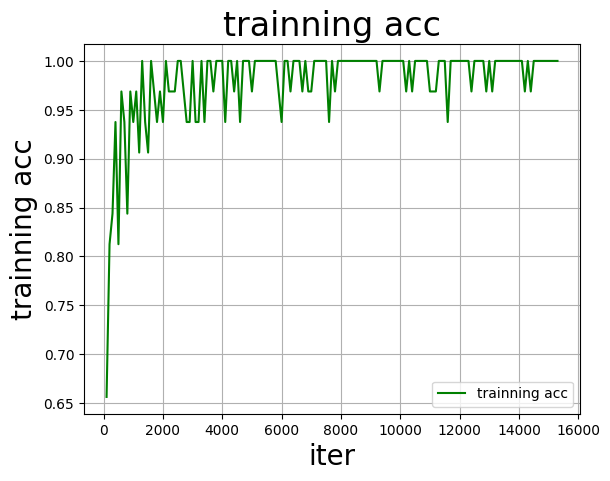

In [6]:
model = my_model(num_classes=23)
model.train()
# 配置loss函数
cross_entropy = paddle.nn.CrossEntropyLoss()
# 配置参数优化器
optimizer = paddle.optimizer.Adam(learning_rate=LR,parameters=model.parameters()) 

steps = 0
Iters, total_loss, total_acc = [], [], []

for epo in range(EPOCH):
    for _, data in enumerate(train_loader()):
        steps += 1
        x_data = data[0]
        y_data = data[1]
        predicts, acc = model(x_data,y_data)

        loss = cross_entropy(predicts, y_data)
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        if steps % 100 == 0:
            Iters.append(steps)
            total_loss.append(loss.numpy()[0])
            total_acc.append(acc.numpy()[0])
            #打印中间过程
            print('epo: {}, step: {}, loss is: {}, acc is: {}'\
                  .format(epo, steps, loss.numpy(), acc.numpy()))


paddle.save(model.state_dict(),"vgg_save_dir_final.pdparams")
draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
draw_process("trainning acc","green",Iters,total_acc,"trainning acc")

# 预测

In [7]:
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import seaborn as sns
import paddle

model__state_dict = paddle.load('vgg_save_dir_final.pdparams')
model_eval = my_model(num_classes=23)
model_eval.set_state_dict(model__state_dict) 
model_eval.eval()

y_p = [] #预测值
y_t = [] #真实值
for batch, (test_X,test_y) in enumerate(eval_loader()):
    y_pred,acc = model_eval(test_X,test_y)
    for i in y_pred:
        y_p.append(np.argmax(i))
        # print(i)
    for i in test_y:
        y_t.append(int(i))

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:143: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(slot[0], (np.ndarray, np.bool, numbers.Number)):
/opt/conda/envs/pyt

In [11]:
print('f1_score:',f1_score(y_t,y_p,average='micro'))
print(classification_report(y_t,y_p,digits=7))

f1_score: 0.9879605983217804
              precision    recall  f1-score   support

           0  0.7500000 0.7500000 0.7500000         4
           1  1.0000000 0.6666667 0.8000000         9
           2  1.0000000 0.8181818 0.9000000        22
           3  1.0000000 1.0000000 1.0000000         4
           4  1.0000000 0.9583333 0.9787234        24
           5  0.7142857 1.0000000 0.8333333         5
           6  0.9852941 0.9962825 0.9907579       269
           7  0.0000000 0.0000000 0.0000000         2
           8  1.0000000 1.0000000 1.0000000        10
           9  1.0000000 1.0000000 1.0000000         6
          10  1.0000000 1.0000000 1.0000000         3
          11  1.0000000 1.0000000 1.0000000        30
          12  1.0000000 0.6666667 0.8000000         3
          13  0.9777778 0.9777778 0.9777778        45
          14  1.0000000 1.0000000 1.0000000        15
          15  0.9844898 0.9958712 0.9901478      1211
          16  0.9926471 1.0000000 0.9963100       40

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/seaborn/matrix.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(data.shape, np.bool)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/seaborn/matrix.py:79: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.bool)
/opt/conda/envs/python35-pad

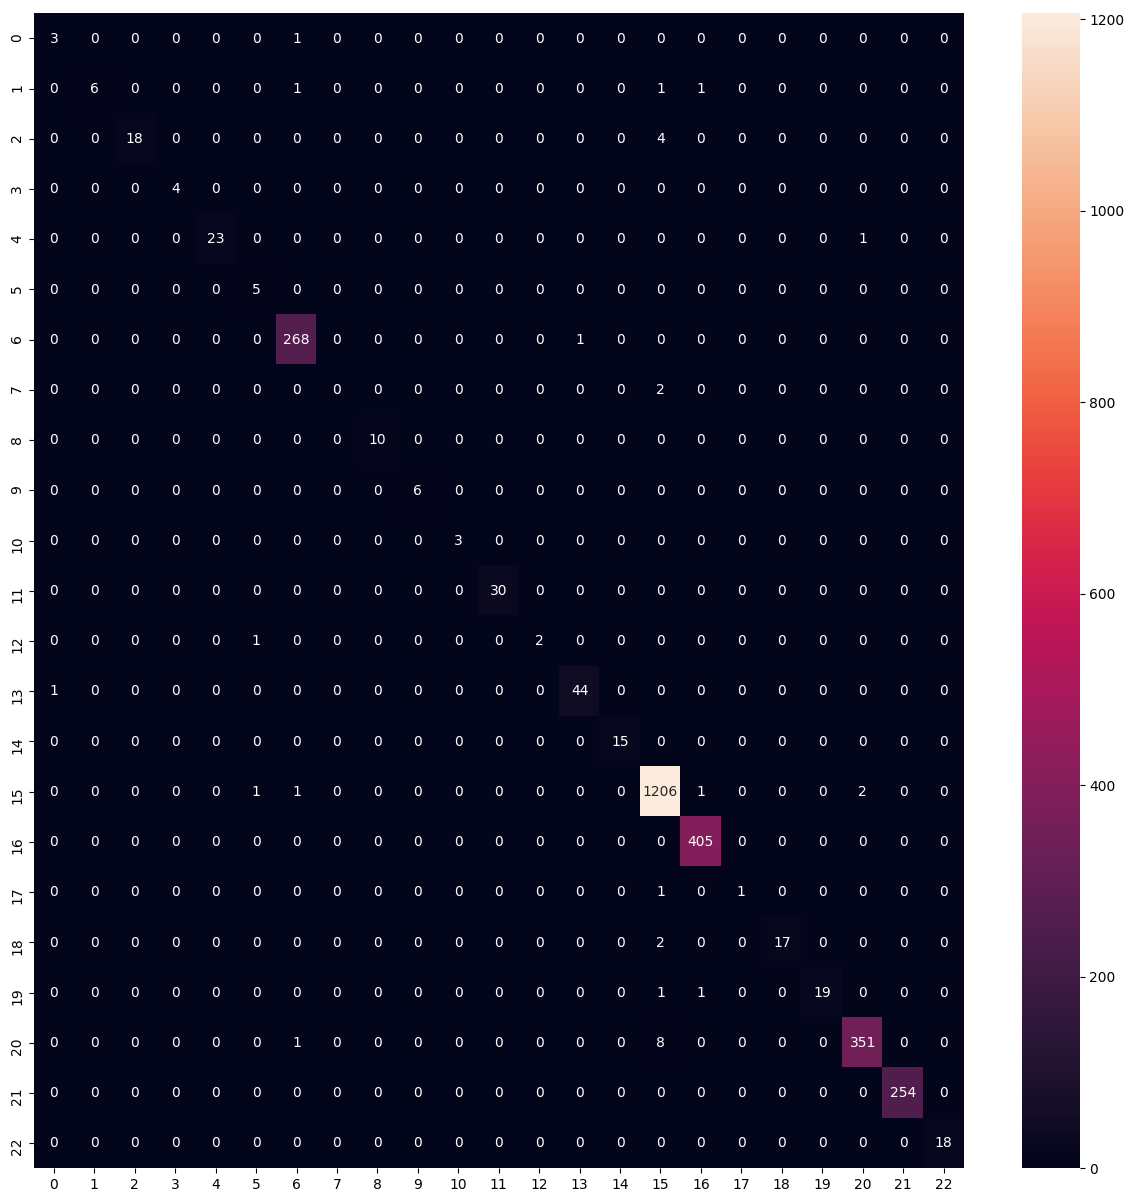

In [9]:
plt.figure(figsize=(15,15))
plt.rcParams['font.sans-serif']='SimHei'
plt.rcParams['axes.unicode_minus']=False

plt.xlabel('pre')
plt.ylabel('real')
sns.heatmap(confusion_matrix(y_t,y_p),annot=True,fmt="d")